In [1]:
import pickle
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from cdlib import algorithms
from tqdm import tqdm

from hp_nlp_graph.bookgraph import BookGraph

Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer', 'bayanpy', 'graph_tool'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer'}


In [2]:
book_number = 7
book = BookGraph(
    book_number, f"data/processed/{book_number}/interactions_by_chapter.pkl", 10
)

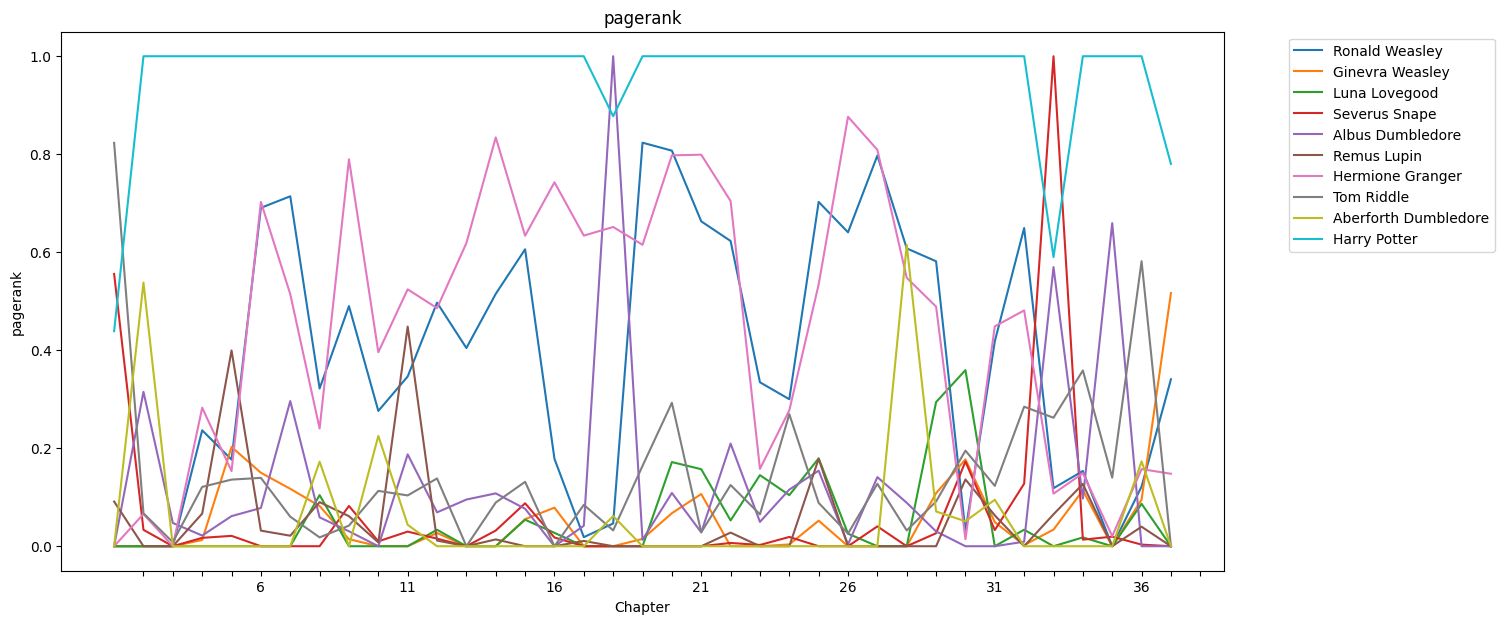

In [3]:
book.plot_metric_over_chapters("pagerank")

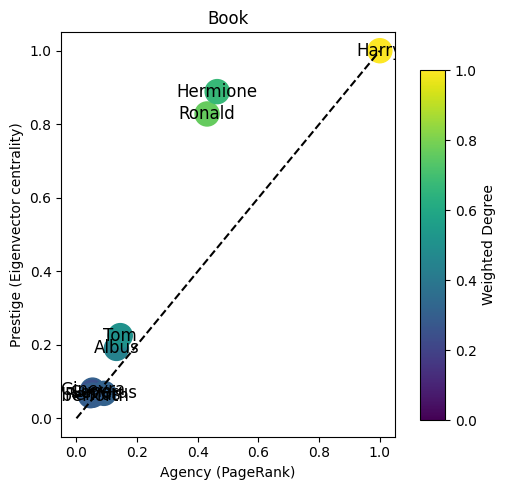

In [4]:
book.plot_centrality_diagram()